In [71]:
#Package Import
import cv2
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from keras.utils import np_utils
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
import cv2
from sklearn.model_selection import train_test_split
from keras import optimizers
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers

#Filepath to import train images
path = '/home/patrick/Downloads/data_dir/train/*/*.png' 
images = glob(path)

#importing train images and labels
train_img = []
train_label = []
for i in images:
    train_img.append(cv2.resize(cv2.imread(i), (100, 100)))
    train_label.append(i.split('/')[-2])

train_img = np.asarray(train_img)
train_label = pd.DataFrame(train_label)

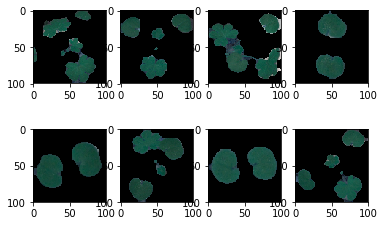

In [72]:
#Data Augmentation to get rid of the background in our train images
clearTrainImg = []
examples = []; getEx = True
for img in train_img:
    blurImg = cv2.GaussianBlur(img, (5, 5), 0)   
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    bMask = mask > 0  
    clear = np.zeros_like(img, np.uint8)
    clear[bMask] = img[bMask]
    clearTrainImg.append(clear)
clearTrainImg = np.asarray(clearTrainImg)
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(clearTrainImg[i])
clearTrainImg = clearTrainImg / 255

I found this kernal by NikKonst very useful and used it as reference for my image import and data augmentation: https://www.kaggle.com/nikkonst/plant-seedlings-with-cnn-and-image-processing

We can see how the masking was able to black out any part of the image that is not the plant. This will make it much easier for the model to identify different characteristics of different plant species. This greatly increased the accuracy of my model. Before I was struggling to get very high validation accuracy and my test fit was just overfitting. I also noticed that the model would predict only one or two classes on unseen data.

In [73]:
#Encoding labels and creating our validation set via train_test_split()
labels = preprocessing.LabelEncoder()
labels.fit(train_label[0])
encodeTrainLabels = labels.transform(train_label[0])
clearTrainLabel = np_utils.to_categorical(encodeTrainLabels)
num_clases = clearTrainLabel.shape[1]

x_train, x_test, y_train, y_test = train_test_split(clearTrainImg, clearTrainLabel, test_size=0.25, random_state=325, stratify = clearTrainLabel)

In [74]:
#Model and train functions
def plant_model():
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(100, 100, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(12))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    return model

def train(model,lr = 0.001, batch = 200, epochs = 20):
    adam  = optimizers.Adam(lr=lr)
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    output = model.fit(x_train,y_train,epochs=epochs, validation_data=(x_test, y_test),batch_size=batch,verbose=0)
    return output.history

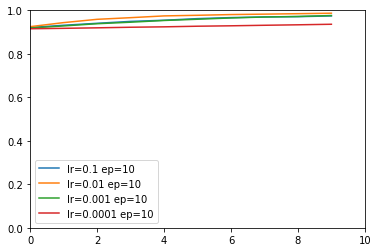

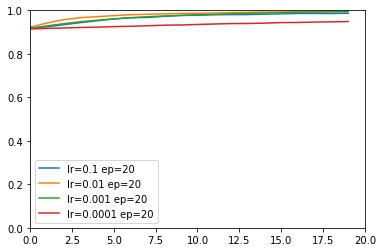

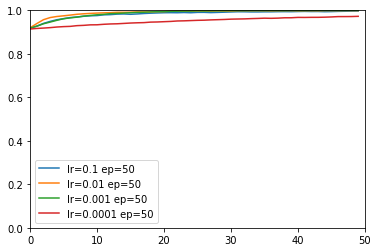

In [62]:
#Investigating different configurations of epochs and learning rates
import matplotlib.pyplot as plt
%matplotlib inline

for ep in [10,20,50]:
    for lr in [0.1,0.01,0.001,0.0001]:
        model = plant_model()
        res = train(model,lr,200,ep)
        plt.ylim(0,1)
        plt.xlim(0,ep)
        plt.plot(res['acc'],label='lr='+str(lr)+' ep='+str(ep))
        plt.legend()
    plt.show()  

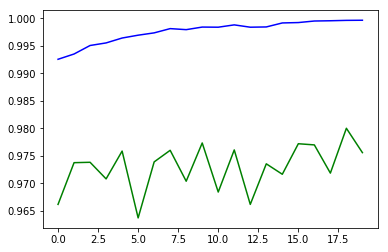

In [66]:
#Generating Validaion accuracy chart from history with default hyperparameters
adam  = optimizers.Adam(lr=0.001)
model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
output = model.fit(x_train,y_train,epochs=20, validation_data=(x_test, y_test),batch_size=200,verbose=0)
plt.plot(output.history['acc'],'b')
plt.plot(output.history['val_acc'],'g')

Both the lr/epoch charts and the validation accuracy chart indicate that the model is likely overfitting. We see very little distinctive difference between different hyperparameters for the model. Also, the validation accuracy does not seem to improve very much with each epoch.

In [85]:
#Second Model to try and reduce overfitting
def plant_model2():
    model = Sequential()
    model.add(Conv2D(32, 3, input_shape=(100, 100, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(32, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Conv2D(128, 3))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64,kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(12))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    adam = optimizers.Adam(lr=0.001)
    model.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])
    return model

For this model I increased the dropout rations pretty significantly and I added l2 regularization on the dense layer before the output layer. I'm hoping this will improve the overfitting problem we saw in the last iteration of the model. I think the model could be further improved with more Data Augmentation. I saw a lot of people on kaggle rotating, flipping, and zoomin in on images to increase the size of the data set and help to prevent overfitting. I think that would really benefit the model. I had a hard time implementing this technique as it would cause my kernel to crash. I'm not sure if there are computational efficiency problems when implementing a lot of image augmentation.

In [86]:
#Running the second model
model = plant_model2()
model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=20, batch_size=200, verbose=2)
scores = model.evaluate(x_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 3562 samples, validate on 1188 samples
Epoch 1/20
 - 10s - loss: 3.0798 - acc: 0.3021 - val_loss: 2.6701 - val_acc: 0.4234
Epoch 2/20
 - 2s - loss: 2.4034 - acc: 0.5609 - val_loss: 2.1989 - val_acc: 0.5606
Epoch 3/20
 - 2s - loss: 2.0401 - acc: 0.6715 - val_loss: 2.5766 - val_acc: 0.3914
Epoch 4/20
 - 2s - loss: 1.7618 - acc: 0.7353 - val_loss: 2.7732 - val_acc: 0.3072
Epoch 5/20
 - 2s - loss: 1.5314 - acc: 0.7855 - val_loss: 2.5005 - val_acc: 0.3409
Epoch 6/20
 - 2s - loss: 1.3529 - acc: 0.8083 - val_loss: 1.9520 - val_acc: 0.4798
Epoch 7/20
 - 2s - loss: 1.1863 - acc: 0.8380 - val_loss: 2.3866 - val_acc: 0.3005
Epoch 8/20
 - 2s - loss: 1.0697 - acc: 0.8498 - val_loss: 2.0163 - val_acc: 0.4099
Epoch 9/20
 - 2s - loss: 0.9472 - acc: 0.8692 - val_loss: 1.9333 - val_acc: 0.4352
Epoch 10/20
 - 2s - loss: 0.8595 - acc: 0.8824 - val_loss: 1.7190 - val_acc: 0.5513
Epoch 11/20
 - 2s - loss: 0.7845 - acc: 0.8897 - val_loss: 1.4866 - val_acc: 0.6684
Epoch 12/20
 - 2s - loss: 0.7126 - a

I think this model will generalize better to new or unseen data. The accuracy on our test set is not as high but I do not think the model is overfitting as much with the changes we made in the second go around.

In [113]:
#Path for test data
path = '/home/patrick/Downloads/data_dir/test/*.png'
files = glob(path)

#reading in test image files and labels (filenames for final output to be uploaded to kaggle)
test_img = []
test_label = []
for i in files:
    test_label.append(i.split('/')[-1])
    test_img.append(cv2.resize(cv2.imread(i), (100, 100)))
test_img = np.asarray(test_img)

#Data Augmentation so data is in the same format as the train data
ct_img = []
examples = []; getEx = True
for i in test_img:
    blurImg = cv2.GaussianBlur(i, (5, 5), 0)   
    hsvImg = cv2.cvtColor(blurImg, cv2.COLOR_BGR2HSV)  
    lower_green = (25, 40, 50)
    upper_green = (75, 255, 255)
    mask = cv2.inRange(hsvImg, lower_green, upper_green)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    bMask = mask > 0  
    clear = np.zeros_like(i, np.uint8)
    clear[bMask] = i[bMask]
    ct_img.append(clear)

#Predicting the class of the test data and formatting the output in the correct format for kaggle upload
ct_img = np.asarray(ct_img)
ct_img = ct_img / 255
pred = model.predict(ct_img)
predNum = np.argmax(pred, axis=1)
predStr = labels.classes_[predNum]

res = {'file': test_label, 'species': predStr}
res = pd.DataFrame(res)
res.to_csv("submission.csv", index=False)

Here I use the masking done by NikKonst again on the test data so the data is in the same format as the data the model was trained with.